In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from fnn.evaluation import *
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt
import pyret

In [3]:
device = torch.device('cuda:0')
cfg = get_custom_cfg('bn_cnn_stack')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_-3.54_pearson_0.6417.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BN_CNN_Stack(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Seq

In [4]:
with h5py.File('/home/TRAIN_DATA/15-10-07/naturalscene.h5', 'r') as f:
    target = f['test']['response']['firing_rate_10ms'][:5, 40:]
    single_trial = []
    for cell in ['cell01', 'cell02', 'cell03', 'cell04', 'cell05']:
        single_trial.append(f['test']['repeats'][cell])
    single_trial = np.stack(single_trial)
single_trial = np.swapaxes(single_trial,0,1)
single_trial = np.swapaxes(single_trial,1,2)[:,40:5996,:]
target = np.swapaxes(target,0,1)[:5956,:]

In [5]:
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 5, device, cfg)
test_pc

0.7327945525090672

In [11]:
noise = single_trial - single_trial.mean(0)

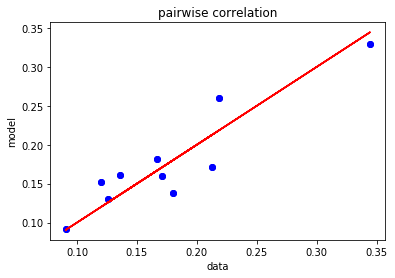

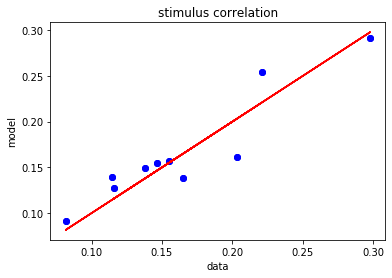

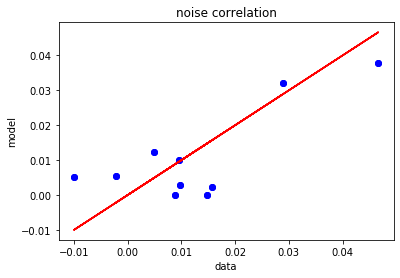

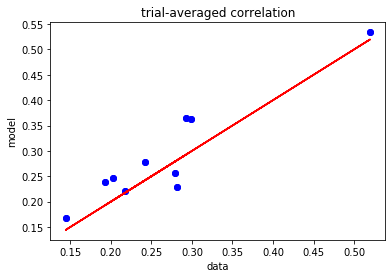

0.091773346


In [30]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0, 0, 0.33, 0], thre=9.35)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

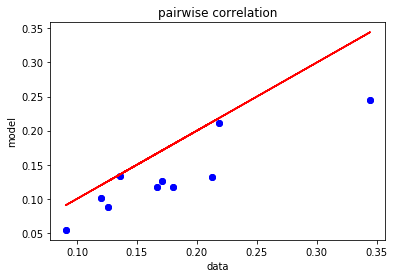

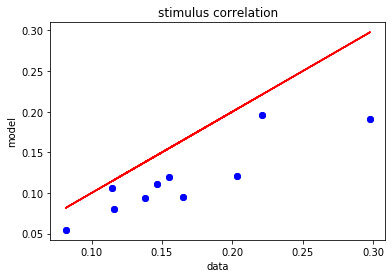

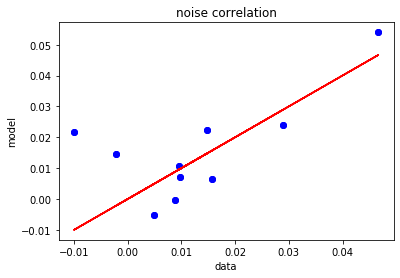

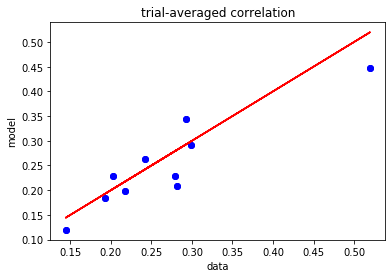

0.0960673


In [8]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.62], gaussian=[0, 0, 0.4, 0], thre=8.47)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

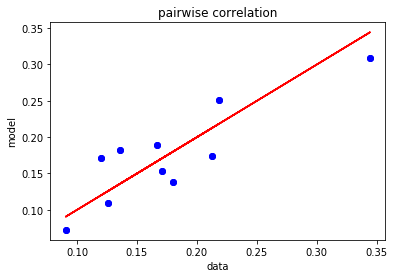

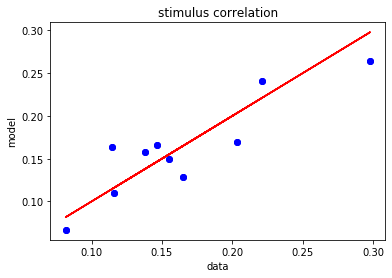

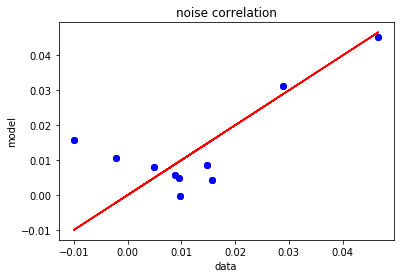

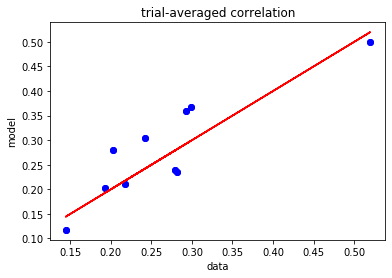

0.10133333


In [42]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0.41, 0., 0.3, 0], thre=10.6)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

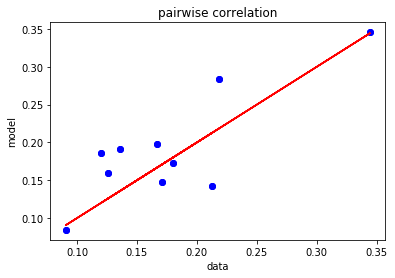

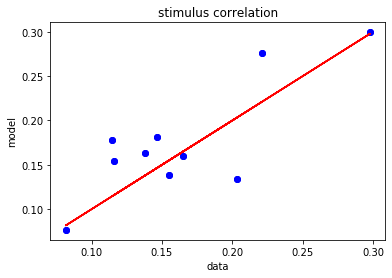

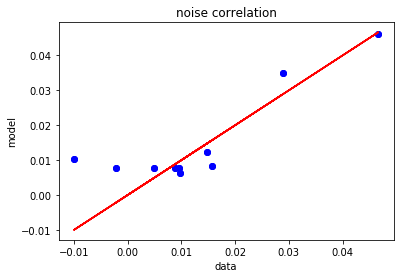

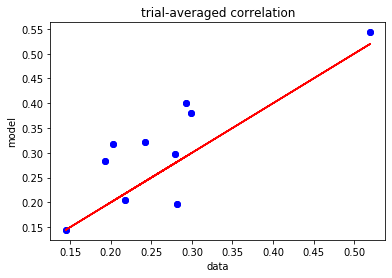

0.08749713


In [129]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.481], gaussian=[0.118, 0.118, 0.292, 0], thre=8.793)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

In [132]:
error(model, test_data, device, single_trial, n_repeats=5, poisson=[None, None, 0.481], gaussian=[0.118, 0.118, 0.292, 0], thre=8.793)

0.6877764861502393

In [119]:
error(model, test_data, device, single_trial, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0], thre=9.35)

0.645739904909542

In [23]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

ac = autocorr(noise[0, : ,0])

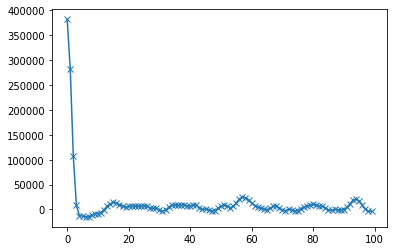

In [23]:
plt.plot(ac[:100], 'x-')

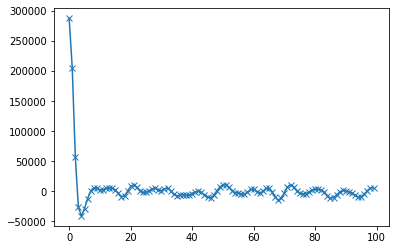

In [24]:
scale_factor = single_trial.mean(axis=1)/single_trial.mean(axis=(0,1))
norm_single_trial = single_trial / np.expand_dims(scale_factor, 1)
norm_noise = norm_single_trial - norm_single_trial.mean(0)
ac = autocorr(norm_noise[3, : ,3])
plt.plot(ac[:100], 'x-')

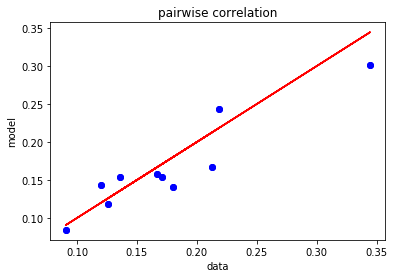

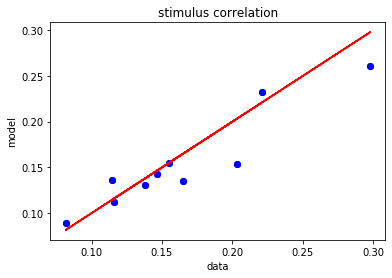

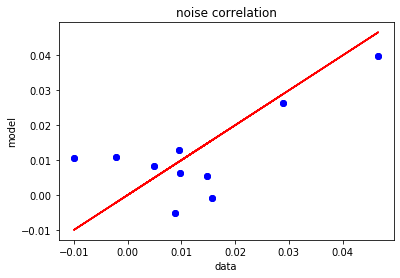

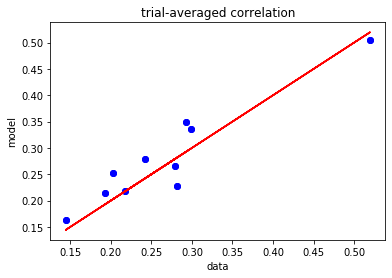

0.093485616


In [70]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0], thre=9.35)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

In [47]:
checkpoint['model_state_dict']['ganglion.0.weight'].shape

torch.Size([5, 5408])

In [51]:
weights = checkpoint['model_state_dict']['ganglion.0.weight'].view(5, 8, 26, 26).cpu().numpy()

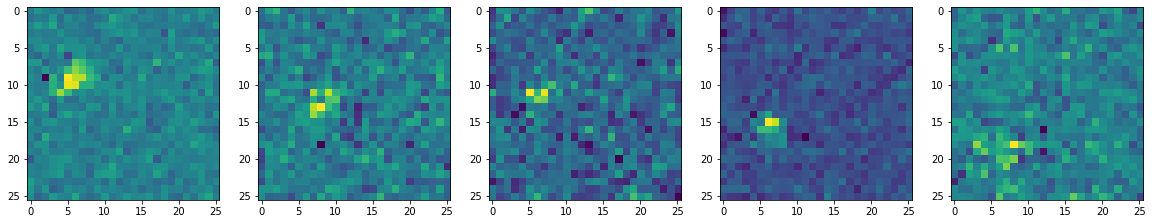

In [65]:
fig, ax = plt.subplots(1, 5, figsize=(20,20))
for i in range(5):
    ax[i].imshow(weights.mean(1)[i])

In [68]:
noise_corr = single_trial_corr_matrix(5,5,single_trial) - stimuli_corr_matrix(5,5,single_trial)
for i in range(5):
    for j in range(i+1, 5):
        print(i, j, noise_corr[i,j])

0 1 0.009811371555099355
0 2 0.04666151791205242
0 3 -0.002217071844486107
0 4 0.015669524035596877
1 2 0.028913699079865324
1 3 0.014818141092981768
1 4 0.0088895998876867
2 3 -0.010023822233756197
2 4 0.004907335494634332
3 4 0.009539640860525417


In [71]:
noise_corr = single_trial_corr_matrix(5,5,pred_single_trial) - stimuli_corr_matrix(5,5,pred_single_trial)
for i in range(5):
    for j in range(i+1, 5):
        print(i, j, noise_corr[i,j])

0 1 0.006261932523381031
0 2 0.03972381864032709
0 3 0.010925706054425277
0 4 -0.0009272316708370809
1 2 0.026307976408426192
1 3 0.0054586286310525645
1 4 -0.005176507852215184
2 3 0.010738442279189964
2 4 0.008190661009705058
3 4 0.013011002725712678


In [94]:
data = loadexpt('15-10-07', 'all', 'whitenoise', 'test', 40, data_path= '/home/TRAIN_DATA')

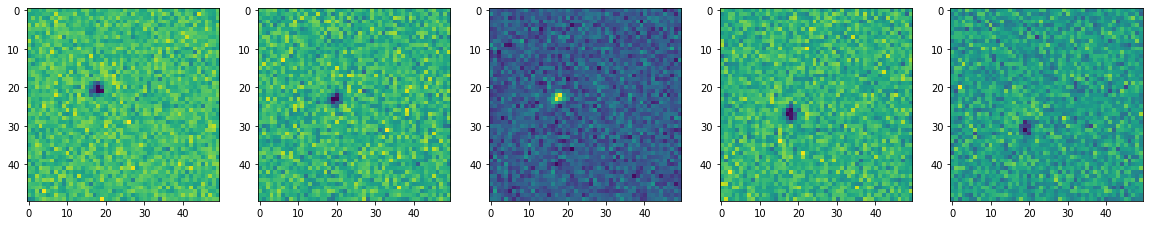

In [113]:
fig, ax = plt.subplots(1, 5, figsize=(20,20))
for i in range(5):
    sta = (np.expand_dims(scipy.stats.zscore(data.y[:, i]), axis=(1,2,3)) * data.X).sum(0)
    decomp_sta = pyret.filtertools.decompose(sta)
    ax[i].imshow(decomp_sta[0])

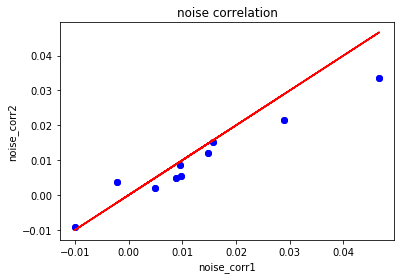

In [138]:
num_cells = 5
diagonal_idxs = list(range(0, num_cells*num_cells, num_cells+1))
noise_corr_1 = single_trial_corr_matrix(5,5,single_trial) - stimuli_corr_matrix(5,5,single_trial)
noise_corr_2 = noise_corr2(single_trial)
noise_corr_1 = np.delete(noise_corr_1.flatten(), diagonal_idxs)
noise_corr_2 = np.delete(noise_corr_2.flatten(), diagonal_idxs)
plt.plot(noise_corr_1, noise_corr_2, 'bo')
plt.plot(noise_corr_1, noise_corr_1, 'r-')
plt.xlabel('noise_corr1')
plt.ylabel('noise_corr2')
plt.title('noise correlation')
plt.show()

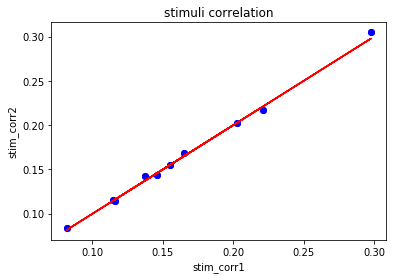

In [146]:
num_cells = 5
diagonal_idxs = list(range(0, num_cells*num_cells, num_cells+1))
stim_corr_1 = stimuli_corr_matrix(5,5,single_trial)
stim_corr_2 = stim_corr2(single_trial)
stim_corr_1 = np.delete(stim_corr_1.flatten(), diagonal_idxs)
stim_corr_2 = np.delete(stim_corr_2.flatten(), diagonal_idxs)
plt.plot(stim_corr_1, stim_corr_2, 'bo')
plt.plot(stim_corr_1, stim_corr_1, 'r-')
plt.xlabel('stim_corr1')
plt.ylabel('stim_corr2')
plt.title('stimuli correlation')
plt.show()

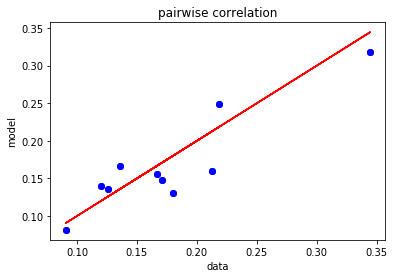

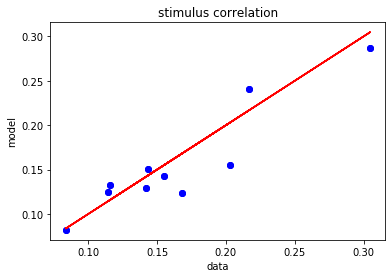

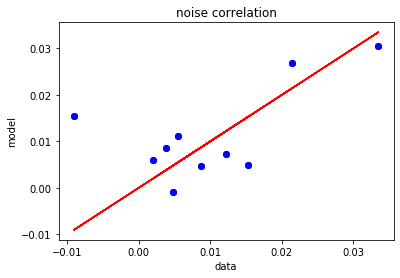

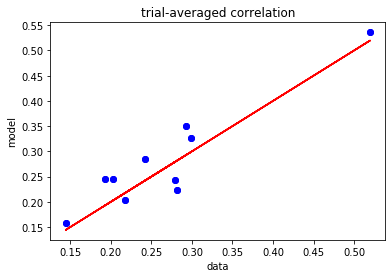

0.09110585


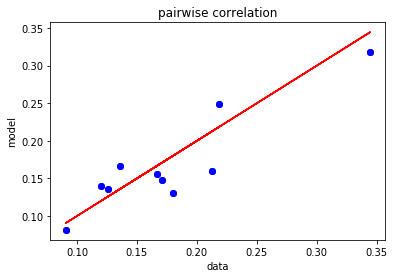

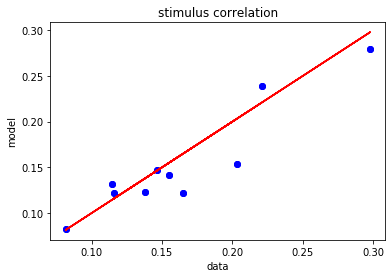

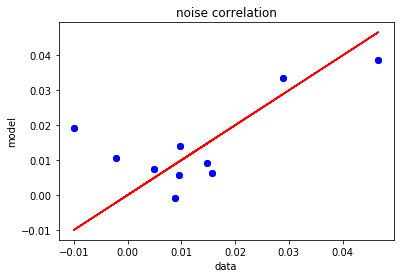

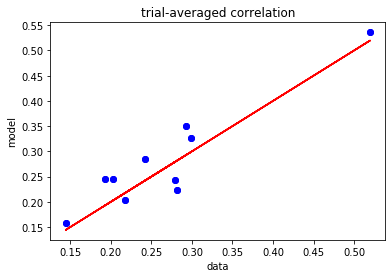

In [155]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0], thre=9.)
correlation_plot_2(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))
correlation_plot(single_trial, pred_single_trial, 5, 5)

In [160]:
single_trial = norm_single_trial
noise = single_trial - single_trial.mean(0)
cov_noise = (np.expand_dims(noise, -1) * np.expand_dims(noise, -2)).mean((1))
V = ((single_trial - single_trial.mean((0,1)))**2).mean((0,1))
noise_corr = cov_noise / np.sqrt(np.expand_dims(V, -1) * np.expand_dims(V, -2))

In [163]:
noise_corr.std(0)/np.abs(noise_corr).mean(0)

array([[0.48935604, 1.0769341 , 0.6615412 , 1.09519702, 0.70085547],
       [1.0769341 , 0.17430743, 0.92939419, 1.12587508, 1.38275156],
       [0.6615412 , 0.92939419, 0.29864715, 1.25819987, 1.080118  ],
       [1.09519702, 1.12587508, 1.25819987, 0.42426486, 0.90558807],
       [0.70085547, 1.38275156, 1.080118  , 0.90558807, 0.37280395]])

In [166]:
noise_corr[:,2,3]

array([-0.01539834, -0.00190698,  0.00545492,  0.00357617, -0.03867274])

In [167]:
noise_corr.std(0)/(noise_corr).mean(0)

array([[ 0.48935604,  1.98849943,  0.6615412 , 23.65300746,  0.70085547],
       [ 1.98849943,  0.17430743,  1.08604646,  1.7326645 ,  1.68472465],
       [ 0.6615412 ,  1.08604646,  0.29864715, -1.74227412,  5.19251016],
       [23.65300746,  1.7326645 , -1.74227412,  0.42426486,  1.46495603],
       [ 0.70085547,  1.68472465,  5.19251016,  1.46495603,  0.37280395]])

In [168]:
noise_corr[:,0,3]

array([ 0.00753218, -0.00098851, -0.0046537 , -0.00570854,  0.00492074])

In [170]:
noise_corr.std(0)/np.sqrt(5)

array([[0.06097568, 0.00786912, 0.01170059, 0.00233175, 0.00356021],
       [0.00786912, 0.04052113, 0.0109657 , 0.00966256, 0.0062875 ],
       [0.01170059, 0.0109657 , 0.07171137, 0.00731592, 0.00704496],
       [0.00233175, 0.00966256, 0.00731592, 0.04963675, 0.00532306],
       [0.00356021, 0.0062875 , 0.00704496, 0.00532306, 0.05132038]])

In [181]:
for i in range(10):
    torch.manual_seed(i)
    e = error(model, test_data, device, single_trial, n_repeats=5, poisson=[None, None, 0.6199], gaussian=[0.3541, 0.08536, 0.31576, 0], thre=8.7845)
    print(i, e)

0 0.7101916100040454
1 0.7642535082921306
2 0.8851208040123367
3 0.7961408656644765
4 0.7472639831131873
5 0.5564845820059817
6 0.6743579546650491
7 0.6141666596340639
8 0.7445415579002315
9 0.6391237722731032


In [8]:
for i in range(10):
    torch.manual_seed(i)
    e = error(model, test_data, device, single_trial, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0], thre=9.)
    print(i, e)

0 0.8198442875208625
1 0.8880483932615165
2 0.7879271223136776
3 0.715396804989785
4 0.6092786324755044
5 0.6985648520182293
6 0.7935225327453314
7 0.7097514641258366
8 0.9333847834694678
9 0.7347397432277013


In [9]:
for i in range(10, 20):
    torch.manual_seed(i)
    e = error(model, test_data, device, single_trial, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0], thre=9.)
    print(i, e)

10 0.677088920765963
11 0.6738446015050652
12 0.6853996859512564
13 0.7628039678655426
14 0.785164971436009
15 0.7697587660139888
16 0.827090223656577
17 0.9450419704394253
18 0.6975717745137398
19 0.9253900639853985


In [10]:
for i in range(10):
    torch.manual_seed(i)
    e = error(model, test_data, device, single_trial, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0], thre=9.35)
    print(i, e)

0 0.8512060497952096
1 0.921868493580731
2 0.8164084373541498
3 0.6951188360419069
4 0.5940923307831684
5 0.7198527471883026
6 0.8064439286192386
7 0.6690956420331318
8 0.9518660787908323
9 0.778012245026317


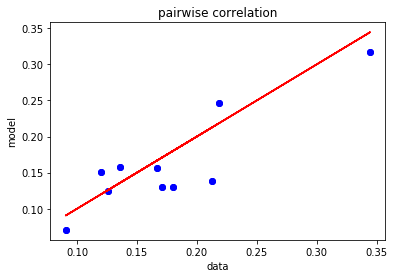

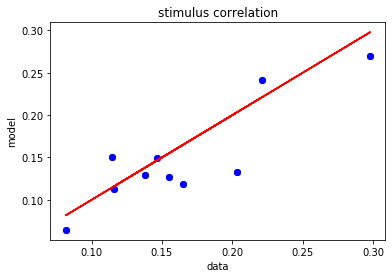

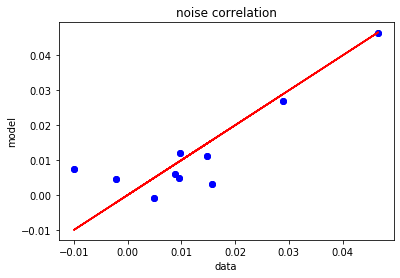

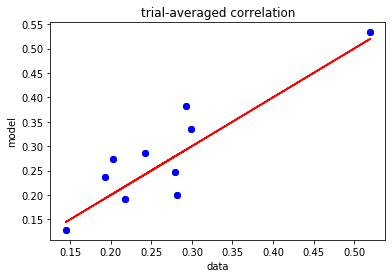

0.091963395


In [7]:
torch.manual_seed(5)
diagonal_idxs = list(range(0, 5*5, 5+1))
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.6199], gaussian=[0.3541, 0.08536, 0.31576, 0], thre=8.7845)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

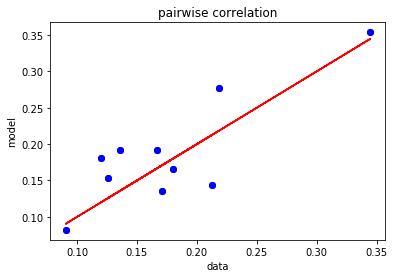

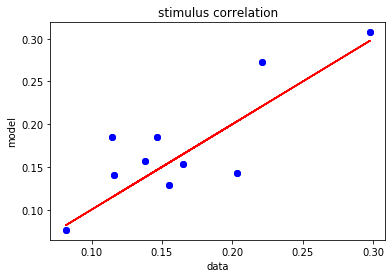

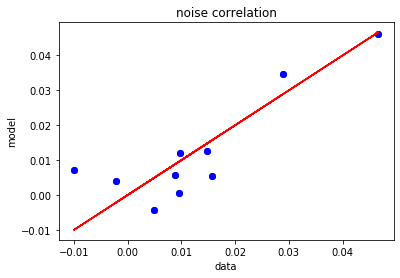

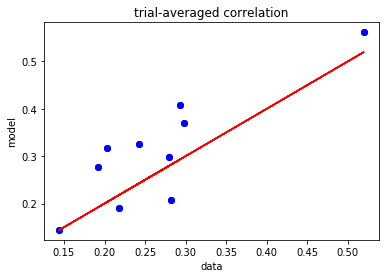

0.07975158


In [46]:
torch.manual_seed(5)
diagonal_idxs = list(range(0, 5*5, 5+1))
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.4853], gaussian=[0.3667, 0.11922, 0.26684, 0], thre=7.23656)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

In [48]:
for i in range(10):
    torch.manual_seed(i)
    e = error2(model, test_data, device, single_trial, n_repeats=15, poisson=[None, None, 0.4853], gaussian=[0.3667, 0.11922, 0.26684, 0], thre=7.23656)
    print(i, e)

0 0.7213635651051195
1 0.7049299383037944
2 0.768231745006515
3 0.6915241897185144
4 0.8119138701008192
5 0.7648880004972626
6 0.6889724277113982
7 0.7321935605071863
8 0.6146271164217318
9 0.7112413076021463


In [10]:
n_cells = 5
n_repeats= 5
poisson=[None, None, 0.6]
gaussian=[0., 0., 0.34, 0]
thre=9.
recorded_fano=0.09188

diagonal_idxs = list(range(0, n_cells*n_cells, n_cells+1))

recorded_corr = single_trial_corr_matrix(n_cells, 5, single_trial)
recorded_stim_corr = stimuli_corr_matrix(n_cells, 5, single_trial)
recorded_noise_corr = recorded_corr - recorded_stim_corr
recorded_corr = np.delete(recorded_corr.flatten(), diagonal_idxs)
recorded_noise_corr = np.delete(recorded_noise_corr.flatten(), diagonal_idxs)

for _ in range(10):
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats, n_cells, poisson, gaussian)
    errors = []
    for _ in range(60):
        pred_single_trial = model_single_trial_post(pred_single_trial_pre, poisson[2], thre)
        pred_corr = single_trial_corr_matrix(n_cells, n_repeats, pred_single_trial)
        pred_stim_corr = stimuli_corr_matrix(n_cells, n_repeats, pred_single_trial)
        pred_noise_corr = pred_corr - pred_stim_corr
        pred_corr = np.delete(pred_corr.flatten(), diagonal_idxs)
        pred_noise_corr = np.delete(pred_noise_corr.flatten(), diagonal_idxs)

        pred_fano = Fano(pred_single_trial)

        error_corr = np.abs(pred_corr - recorded_corr).sum() / recorded_corr.sum()
        error_noise = np.abs(pred_noise_corr - recorded_noise_corr).sum() / np.abs(recorded_noise_corr).sum()
        error_fano = np.abs(pred_fano - recorded_fano) / recorded_fano
        error = error_corr + error_noise + error_fano

        errors.append(error)
    errors = np.array(errors)
    error = errors.min()
    print(error)

0.6084133159657373
0.5230165436761663
0.6276417097337011
0.4390797668899211
0.5441373516807514
0.4945957383321324
0.4251497729073512
0.6717099358883333
0.6677697573335319
0.5969968656650662


In [9]:
n_cells = 5
n_repeats= 15
poisson=[None, None, 0.4853]
gaussian=[0.3667, 0.11922, 0.26684, 0]
thre=7.23656
recorded_fano=0.09188

diagonal_idxs = list(range(0, n_cells*n_cells, n_cells+1))

recorded_corr = single_trial_corr_matrix(n_cells, 5, single_trial)
recorded_stim_corr = stimuli_corr_matrix(n_cells, 5, single_trial)
recorded_noise_corr = recorded_corr - recorded_stim_corr
recorded_corr = np.delete(recorded_corr.flatten(), diagonal_idxs)
recorded_noise_corr = np.delete(recorded_noise_corr.flatten(), diagonal_idxs)

for _ in range(10):
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats, n_cells, poisson, gaussian)
    errors = []
    for _ in range(20):
        pred_single_trial = model_single_trial_post(pred_single_trial_pre, poisson[2], thre)
        pred_corr = single_trial_corr_matrix(n_cells, n_repeats, pred_single_trial)
        pred_stim_corr = stimuli_corr_matrix(n_cells, n_repeats, pred_single_trial)
        pred_noise_corr = pred_corr - pred_stim_corr
        pred_corr = np.delete(pred_corr.flatten(), diagonal_idxs)
        pred_noise_corr = np.delete(pred_noise_corr.flatten(), diagonal_idxs)

        pred_fano = Fano(pred_single_trial)

        error_corr = np.abs(pred_corr - recorded_corr).sum() / recorded_corr.sum()
        error_noise = np.abs(pred_noise_corr - recorded_noise_corr).sum() / np.abs(recorded_noise_corr).sum()
        error_fano = np.abs(pred_fano - recorded_fano) / recorded_fano
        error = error_corr + error_noise + error_fano

        errors.append(error)
    errors = np.array(errors)
    error = errors.min()
    print(error)

0.6376508767677315
0.6396328215120545
0.6633243769545073
0.6150689825928943
0.6019715680580083
0.6189916240949109
0.6659116752319174
0.6449426363188927
0.6361978246161044
0.5801950025256376


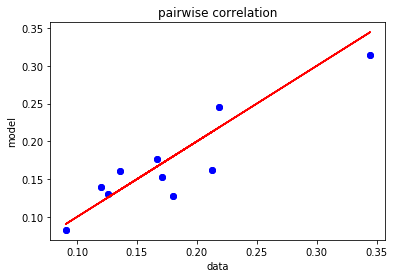

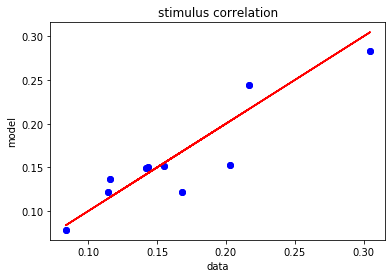

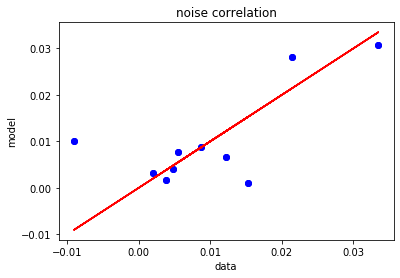

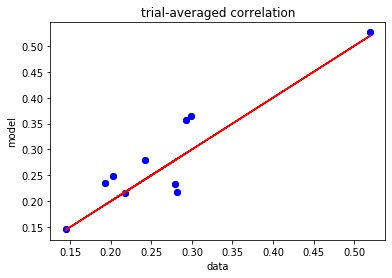

0.09314914


In [20]:
torch.manual_seed(4)
diagonal_idxs = list(range(0, 5*5, 5+1))
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0.], thre=9.35)
correlation_plot_2(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

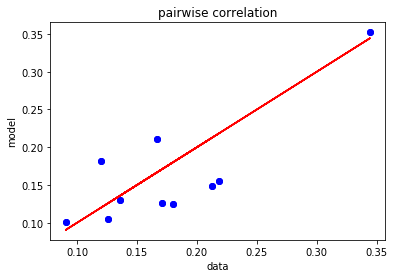

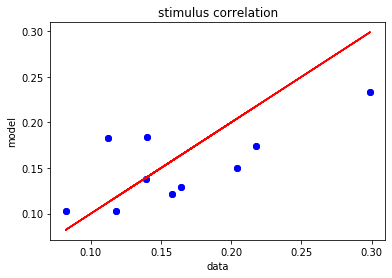

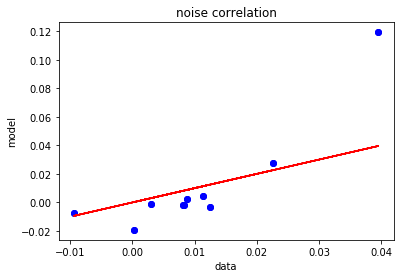

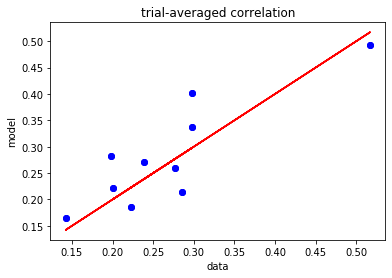

0.114501506


In [177]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.8], gaussian=[1., 0., 0., 0], thre=9.)
correlation_plot_2(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

In [178]:
noise = pred_single_trial - pred_single_trial.mean(0)
cov_noise = (np.expand_dims(noise, -1) * np.expand_dims(noise, -2)).mean((1))
V = ((pred_single_trial - pred_single_trial.mean((0,1)))**2).mean((0,1))
noise_corr = cov_noise / np.sqrt(np.expand_dims(V, -1) * np.expand_dims(V, -2))
noise_corr[:,2,3]

array([-0.00420992, -0.01248064, -0.00436879, -0.00634602, -0.00818012],
      dtype=float32)

In [14]:
torch.manual_seed(5)
diagonal_idxs = list(range(0, 5*5, 5+1))
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.6199], gaussian=[0.3541, 0.08536, 0.31576, 0], thre=8.7845)
noise = pred_single_trial - pred_single_trial.mean(0)
cov_noise = (np.expand_dims(noise, -1) * np.expand_dims(noise, -2)).mean((1))
V = ((pred_single_trial - pred_single_trial.mean((0,1)))**2).mean((0,1))
noise_corr = cov_noise / np.sqrt(np.expand_dims(V, -1) * np.expand_dims(V, -2))
noise_corr.std(0)/np.sqrt(5)

array([[0.00478537, 0.00417282, 0.00217803, 0.00185059, 0.00198791],
       [0.00417282, 0.01251976, 0.00393935, 0.001527  , 0.00182186],
       [0.00217803, 0.00393935, 0.0160968 , 0.00239847, 0.00280269],
       [0.00185059, 0.001527  , 0.00239847, 0.00225944, 0.00360552],
       [0.00198791, 0.00182186, 0.00280269, 0.00360552, 0.00314123]],
      dtype=float32)

In [16]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0.], thre=9.35)
noise = pred_single_trial - pred_single_trial.mean(0)
cov_noise = (np.expand_dims(noise, -1) * np.expand_dims(noise, -2)).mean((1))
V = ((pred_single_trial - pred_single_trial.mean((0,1)))**2).mean((0,1))
noise_corr = cov_noise / np.sqrt(np.expand_dims(V, -1) * np.expand_dims(V, -2))
noise_corr.std(0)/np.sqrt(5)

array([[0.00494005, 0.00108977, 0.00506143, 0.00096194, 0.00272671],
       [0.00108977, 0.02015314, 0.00373551, 0.00230539, 0.00204946],
       [0.00506143, 0.00373551, 0.01091926, 0.00230337, 0.00281342],
       [0.00096194, 0.00230539, 0.00230337, 0.00616313, 0.00067818],
       [0.00272671, 0.00204946, 0.00281342, 0.00067818, 0.00830325]],
      dtype=float32)

In [17]:
noise_corr = []
for i in range(10):
    torch.manual_seed(i)
    pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0.], thre=9.35)
    noise_corr.append(noise_corr2(pred_single_trial))
noise_corr = np.array(noise_corr)
noise_corr.std(0)

array([[0.00568521, 0.00216515, 0.00453305, 0.00302138, 0.00276733],
       [0.00216515, 0.00889395, 0.00606252, 0.00432114, 0.00255597],
       [0.00453305, 0.00606252, 0.01532493, 0.00253236, 0.00535848],
       [0.00302138, 0.00432114, 0.00253236, 0.00741342, 0.00384695],
       [0.00276733, 0.00255597, 0.00535848, 0.00384695, 0.00627485]],
      dtype=float32)

In [38]:
noise_corr = []
for i in range(10):
    torch.manual_seed(i)
    pred_single_trial = model_single_trial(model, test_data, device, n_repeats=10, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0.], thre=9.35)
    noise_corr.append(noise_corr2(pred_single_trial))
noise_corr = np.array(noise_corr)
noise_corr.std(0)

array([[0.00588019, 0.00126472, 0.00377247, 0.00114981, 0.0018761 ],
       [0.00126472, 0.00735675, 0.00518739, 0.00272502, 0.00160345],
       [0.00377247, 0.00518739, 0.0128995 , 0.00150267, 0.00335367],
       [0.00114981, 0.00272502, 0.00150267, 0.00468072, 0.00302614],
       [0.0018761 , 0.00160345, 0.00335367, 0.00302614, 0.00399785]],
      dtype=float32)

In [39]:
noise_corr = []
for i in range(10):
    torch.manual_seed(i)
    pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0.], thre=9.35)
    noise_corr.append(noise_corr2(pred_single_trial[:,-1000:,:]))
noise_corr = np.array(noise_corr)
noise_corr.std(0)

array([[0.01428509, 0.00924034, 0.01065524, 0.00721738, 0.00615916],
       [0.00924034, 0.02287834, 0.01910037, 0.01086602, 0.00983689],
       [0.01065524, 0.01910037, 0.03281261, 0.00786779, 0.00699227],
       [0.00721738, 0.01086602, 0.00786779, 0.01032555, 0.00730378],
       [0.00615916, 0.00983689, 0.00699227, 0.00730378, 0.01319719]],
      dtype=float32)

In [40]:
noise_corr = []
for i in range(10):
    torch.manual_seed(i)
    pred_single_trial = model_single_trial(model, test_data, device, n_repeats=10, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0.], thre=9.35)
    noise_corr.append(noise_corr2(pred_single_trial[:,-1000:,:]))
noise_corr = np.array(noise_corr)
noise_corr.std(0)

array([[0.01111795, 0.00497864, 0.0079135 , 0.00457476, 0.00158419],
       [0.00497864, 0.01750653, 0.01664201, 0.0072996 , 0.0062254 ],
       [0.0079135 , 0.01664201, 0.02267748, 0.0064982 , 0.00405891],
       [0.00457476, 0.0072996 , 0.0064982 , 0.01104074, 0.00418443],
       [0.00158419, 0.0062254 , 0.00405891, 0.00418443, 0.01119727]],
      dtype=float32)

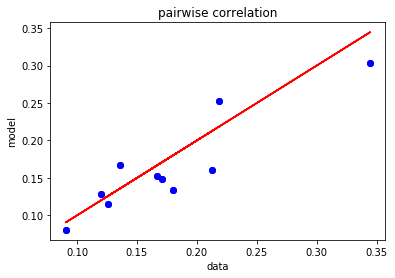

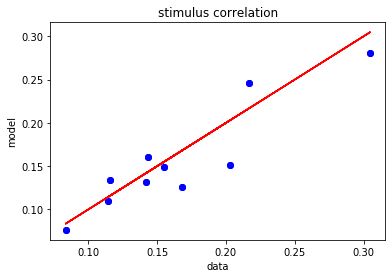

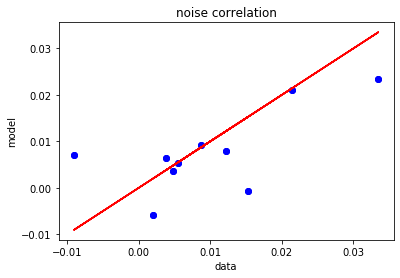

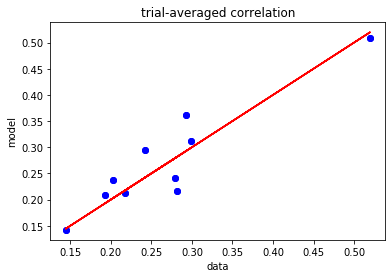

0.092434004


In [19]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0., 0., 0.34, 0.], thre=9.35)
correlation_plot_2(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

In [25]:
single_trial = norm_single_trial
noise = single_trial - single_trial.mean(0)
cov_noise = (np.expand_dims(noise, -1) * np.expand_dims(noise, -2)).mean((1))
V = ((single_trial - single_trial.mean((0,1)))**2).mean((0,1))
noise_corr = cov_noise / np.sqrt(np.expand_dims(V, -1) * np.expand_dims(V, -2))
noise_corr.std(0)

array([[0.13634577, 0.01759589, 0.02616331, 0.00521394, 0.00796087],
       [0.01759589, 0.09060799, 0.02452005, 0.02160613, 0.01405927],
       [0.02616331, 0.02452005, 0.1603515 , 0.0163589 , 0.01575301],
       [0.00521394, 0.02160613, 0.0163589 , 0.11099115, 0.01190273],
       [0.00796087, 0.01405927, 0.01575301, 0.01190273, 0.11475586]])

In [29]:
single_trial_short = norm_single_trial[:, 2000:3000, :]
noise = single_trial_short - single_trial_short.mean(0)
cov_noise = (np.expand_dims(noise, -1) * np.expand_dims(noise, -2)).mean((1))
V = ((single_trial_short - single_trial_short.mean((0,1)))**2).mean((0,1))
noise_corr = cov_noise / np.sqrt(np.expand_dims(V, -1) * np.expand_dims(V, -2))
noise_corr.std(0)

array([[0.0824549 , 0.04774008, 0.04806336, 0.01911687, 0.02452519],
       [0.04774008, 0.1809442 , 0.11625139, 0.01679194, 0.02451604],
       [0.04806336, 0.11625139, 0.24500454, 0.02418985, 0.02786569],
       [0.01911687, 0.01679194, 0.02418985, 0.09300878, 0.01894348],
       [0.02452519, 0.02451604, 0.02786569, 0.01894348, 0.16003143]])

In [31]:
with h5py.File('/home/TRAIN_DATA/15-10-07/whitenoise.h5', 'r') as f:
    target = f['test']['response']['firing_rate_10ms'][:5, 40:]
    single_trial = []
    for cell in ['cell01', 'cell02', 'cell03', 'cell04', 'cell05']:
        single_trial.append(f['test']['repeats'][cell])
    single_trial = np.stack(single_trial)
single_trial = np.swapaxes(single_trial,0,1)
single_trial = np.swapaxes(single_trial,1,2)[:,40:5996,:]

In [32]:
scale_factor = single_trial.mean(axis=1)/single_trial.mean(axis=(0,1))
norm_single_trial = single_trial / np.expand_dims(scale_factor, 1)

In [35]:
single_trial = norm_single_trial
noise = single_trial - single_trial.mean(0)
cov_noise = (np.expand_dims(noise, -1) * np.expand_dims(noise, -2)).mean((1))
V = ((single_trial - single_trial.mean((0,1)))**2).mean((0,1))
noise_corr = cov_noise / np.sqrt(np.expand_dims(V, -1) * np.expand_dims(V, -2))
noise_corr.std(0)

array([[0.10260683, 0.00547041, 0.00800953, 0.00814479, 0.00291929],
       [0.00547041, 0.21018767, 0.01305861, 0.00339103, 0.00484655],
       [0.00800953, 0.01305861, 0.87812547, 0.00377336, 0.01075947],
       [0.00814479, 0.00339103, 0.00377336, 0.07778105, 0.0038964 ],
       [0.00291929, 0.00484655, 0.01075947, 0.0038964 , 0.27778485]])

In [37]:
noise_corr2(single_trial)

array([[ 2.34679588e-01, -1.34577980e-03,  4.24642279e-03,
         9.73194926e-03, -7.66662119e-04],
       [-1.34577980e-03,  4.94851309e-01, -9.27187482e-04,
        -5.05209872e-03, -5.13134453e-03],
       [ 4.24642279e-03, -9.27187482e-04,  6.78246827e-01,
         1.43704122e-03,  5.10143513e-03],
       [ 9.73194926e-03, -5.05209872e-03,  1.43704122e-03,
         2.00722915e-01,  4.48226355e-04],
       [-7.66662119e-04, -5.13134453e-03,  5.10143513e-03,
         4.48226355e-04,  4.34074988e-01]])

In [34]:
single_trial_short = norm_single_trial[:, -1000:, :]
noise = single_trial_short - single_trial_short.mean(0)
cov_noise = (np.expand_dims(noise, -1) * np.expand_dims(noise, -2)).mean((1))
V = ((single_trial_short - single_trial_short.mean((0,1)))**2).mean((0,1))
noise_corr = cov_noise / np.sqrt(np.expand_dims(V, -1) * np.expand_dims(V, -2))
noise_corr.std(0)

array([[0.09947475, 0.01078241, 0.03005786, 0.01729718, 0.01559857],
       [0.01078241, 0.20264612, 0.0243253 , 0.0135695 , 0.02377153],
       [0.03005786, 0.0243253 , 1.16439375, 0.00258117, 0.02594576],
       [0.01729718, 0.0135695 , 0.00258117, 0.05485059, 0.00852185],
       [0.01559857, 0.02377153, 0.02594576, 0.00852185, 0.31811975]])

In [40]:
from scipy.optimize import minimize
import time

n_cells = 5
n_repeats = 5
diagonal_idxs = list(range(0, n_cells*n_cells, n_cells+1))
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=5, n_cells=5, poisson=[None, None, None], gaussian=[0., 0., 0.34, 0])
recorded_corr = single_trial_corr_matrix(n_cells, 5, single_trial)
recorded_stim_corr = stimuli_corr_matrix(n_cells, 5, single_trial)
recorded_noise_corr = recorded_corr - recorded_stim_corr
recorded_corr = np.delete(recorded_corr.flatten(), diagonal_idxs)
recorded_noise_corr = np.delete(recorded_noise_corr.flatten(), diagonal_idxs)
recorded_fano=0.09188
    
def error_post(params):

    errors = []
    for _ in range(60):
        pred_single_trial = model_single_trial_post(pred_single_trial_pre, params[0], params[1])
        pred_corr = single_trial_corr_matrix(n_cells, n_repeats, pred_single_trial)
        pred_stim_corr = stimuli_corr_matrix(n_cells, n_repeats, pred_single_trial)
        pred_noise_corr = pred_corr - pred_stim_corr
        pred_corr = np.delete(pred_corr.flatten(), diagonal_idxs)
        pred_noise_corr = np.delete(pred_noise_corr.flatten(), diagonal_idxs)

        pred_fano = Fano(pred_single_trial)

        error_corr = np.abs(pred_corr - recorded_corr).sum() / recorded_corr.sum()
        error_noise = np.abs(pred_noise_corr - recorded_noise_corr).sum() / np.abs(recorded_noise_corr).sum()
        error_fano = np.abs(pred_fano - recorded_fano) / recorded_fano
        error = error_corr + error_noise + error_fano

        errors.append(error)
    errors = np.array(errors)
    error = errors.min()
    return error

x0 = (0.6, 9.)
options={'maxfev': 500, 'disp': True}
bounds = ((1./3., 1.0), (5., 15.))
t_start = time.time()
res = minimize(error_post, x0, method='Powell', bounds=bounds, options=options)
t_stop = time.time()
print(res.x)
print(t_stop - t_start)


def error_post2(params):

    errors = []
    k3 = 1. / params[0]
    thre = params[1] * 10. + 10.
    
    for _ in range(60):
        pred_single_trial = model_single_trial_post(pred_single_trial_pre, k3, thre)
        pred_corr = single_trial_corr_matrix(n_cells, n_repeats, pred_single_trial)
        pred_stim_corr = stimuli_corr_matrix(n_cells, n_repeats, pred_single_trial)
        pred_noise_corr = pred_corr - pred_stim_corr
        pred_corr = np.delete(pred_corr.flatten(), diagonal_idxs)
        pred_noise_corr = np.delete(pred_noise_corr.flatten(), diagonal_idxs)

        pred_fano = Fano(pred_single_trial)

        error_corr = np.abs(pred_corr - recorded_corr).sum() / recorded_corr.sum()
        error_noise = np.abs(pred_noise_corr - recorded_noise_corr).sum() / np.abs(recorded_noise_corr).sum()
        error_fano = np.abs(pred_fano - recorded_fano) / recorded_fano
        error = error_corr + error_noise + error_fano

        errors.append(error)
    errors = np.array(errors)
    error = errors.min()
    return error

x0 = (1. / 0.6, -0.1)
options={'maxfev': 500, 'disp': True}
bounds = ((1., 3.), (-0.5, 0.5))
#bounds = ((1./0.7, 1./0.5), (-0.2, 0.))
t_start = time.time()
res = minimize(error_post2, x0, method='Powell', bounds=bounds, options=options)
t_stop = time.time()
print(res.x)
print(t_stop - t_start)

Optimization terminated successfully.
         Current function value: 0.838718
         Iterations: 2
         Function evaluations: 92
[ 0.7102426  11.18033989]
638.2822470664978
Optimization terminated successfully.
         Current function value: 0.969653
         Iterations: 2
         Function evaluations: 71
[ 2.53791404 -0.16003753]
476.647661447525
